In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import scipy.cluster
import shap

from dk_model import DeepKrigingTrainer


In [2]:
import sys
print(sys.version)

3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]


In [3]:
deposit_data = pd.read_csv("../Curated_data/final_dataset_1_no_0.csv", low_memory=False)


In [4]:
deposit_data.head(3)

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,...,phi_478,phi_479,phi_480,phi_481,phi_482,phi_483,phi_484,phi_485,phi_486,phi_487
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,0.88,0.127305,0.25,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,0.88,0.160479,0.25,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,0.99,0.128743,0.25,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
#covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm', 'Random_Values'] 

covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm'] 
phi_columns = deposit_data.columns[10:].tolist()

print(phi_columns[-1])

deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

deposit_data[phi_columns + covariates]

p = len(phi_columns) + len(covariates)

phi_487


# Deepkriging train test split

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

phi_columns = deposit_data.columns[10:-1].tolist()

torch.manual_seed(42)
np.random.seed(42)

p = len(phi_columns) + len(covariates)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(deposit_data[phi_columns + covariates],
                                                    deposit_data['Density_gcm3'],
                                                    test_size=0.2, random_state=42)

# Define the neural network
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

# Training loop
for step in range(601):
    pre = model(torch.tensor(X_train.values, dtype=torch.float32))
    mse = mse_loss(pre, torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32))
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()


# Store metrics for this fold
test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()

def print_metrics(true_values, predicted_values, dataset_name, p):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    print(f"{dataset_name} MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


# Print metrics for the test set
print_metrics(y_test.values, test_predictions, "Test", p)



Test MSE: 0.0022, MAE: 0.0324, R2: 0.8506


In [12]:
trainer_regular = DeepKrigingTrainer(deposit_data, covariates, regular_nn=False, plot_errors=False)
trainer_regular.train_neural_network(mode="regular", test_size=0.2)
test_predictions = trainer_regular.test_predictions


Average Metrics Across Folds:
  Average MSE: 0.0021
  Average MAE: 0.0328
  Average adjusted R2: -1.5496
  STD MSE: 0.0000
  STD MAE: 0.0000
  STD adjusted R2: 0.0000


# Combinations for the phi feature

In [14]:
len(phi_columns)

487

In [15]:
# Create all possible combinations of columns and generate a new DataFrame for each combination
import pandas as pd
from itertools import combinations
X_phi_c = X_test.iloc[:, len(phi_columns):]
X_easy = X_phi_c
X_phi = X_test.iloc[:, :len(phi_columns)]

permutations_phi = []
Q = []
#covariates + phi - active variable
size = len(covariates) + 1 - 1
Q.append(size)

#To get all combinations in X_easy 
numcovar = len(covariates) - 1

#The first df corresponds to the full dataset
permutations_phi.append(pd.concat([X_easy.copy(), X_phi], axis=1))

#Compute all X_easy combinations and then append X_phi
for r in range(1, len(X_easy.columns) + 1):
    for combo in combinations(X_easy.columns, r):
        new_df = X_easy.copy()
        new_df[list(combo)] = 0
        permutations_phi.append(pd.concat([new_df, X_phi], axis=1))

permutations_phi_0 = []

# Create a DataFrame with all columns in X_phi set to 0
zero_X_phi = pd.DataFrame(0, index=X_phi.index, columns=X_phi.columns)

#The first df corresponds to the full dataset, but with the phi's set to 0
permutations_phi_0.append(pd.concat([X_easy.copy(), zero_X_phi], axis=1))

#Compute all X_easy combinations and then append the phi columns with 0s (these are the subsets without the j variable)
for r in range(1, len(X_easy.columns) + 1):
    for combo in combinations(X_easy.columns, r):
        new_df = X_easy.copy()
        new_df[list(combo)] = 0
        permutations_phi_0.append(pd.concat([new_df, zero_X_phi], axis=1))
        n_features = len(X_easy.columns[-numcovar:]) + 1 - len(combo)
        Q.append(n_features)



permutations_phi = [df[X_test.columns] for df in permutations_phi]
permutations_phi_0 = [df[X_test.columns] for df in permutations_phi_0]

Q_phi = Q

# Combinations for the rest of the features

In [16]:
import pandas as pd
from itertools import combinations

X_CP_Total = X_test[['CP_Total']]
selected_columns = [col for col in X_test.columns if col != 'CP_Total']
X_CP_Total_c = X_test[selected_columns]

new_dataframes_CP_Total = []
Q = []
new_dataframes_CP_Total.append(pd.concat([X_CP_Total_c.copy(), X_CP_Total], axis=1))

numcovar = len(covariates)-1
#covariates + phi - active variable
size = len(covariates)-1+1
Q.append(size)

for r in range(1, len(X_CP_Total_c.columns[-numcovar:]) + 1):
    for combo in combinations(X_CP_Total_c.columns[-numcovar:], r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total.append(pd.concat([new_df, X_CP_Total], axis=1))
        # 4 features + phi feature - the number of features being 0 is the number of active features 


for idx in range(len(new_dataframes_CP_Total)):
    new_df = new_dataframes_CP_Total[idx].copy()
    for col in new_df.columns[:6403]:
        new_df[col].values[:] = 0
    new_dataframes_CP_Total.append(new_df)



# Subtract one from each element using list comprehension



new_dataframes_CP_Total_aux = new_dataframes_CP_Total

# Assuming X_CP_Total_c is your existing DataFrame and X_CP_Total is another DataFrame
# Create all possible combinations of columns and generate a new DataFrame for each combination
new_dataframes_CP_Total_0 = []

# Create a DataFrame with all columns in X_CP_Total set to 0
zero_X_CP = pd.DataFrame(0, index=X_CP_Total.index, columns=X_CP_Total.columns)

new_dataframes_CP_Total_0.append(pd.concat([X_CP_Total_c.copy(), zero_X_CP], axis=1))


for r in range(1, len(X_CP_Total_c.columns[-numcovar:]) + 1):
    for combo in combinations(X_CP_Total_c.columns[-numcovar:], r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total_0.append(pd.concat([new_df, zero_X_CP], axis=1))
        n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
        Q.append(n_features)



for idx in range(len(new_dataframes_CP_Total_0)):
    new_df = new_dataframes_CP_Total_0[idx].copy()
    for col in new_df.columns[:6403]:
        new_df[col].values[:] = 0
    new_dataframes_CP_Total_0.append(new_df)


result_list = [x - 1 for x in Q]
Q = Q + result_list


all_subgroups_CP_Total = new_dataframes_CP_Total + new_dataframes_CP_Total_0
len(all_subgroups_CP_Total)

64

In [17]:
import pandas as pd
from itertools import combinations

# Create all possible combinations of columns and generate a new DataFrame for each combination
def subgroups(column):

# Column of interest
    X_column = X_test[[column]]

# Select all other columns
    selected_columns = [col for col in X_test.columns if col != column]
    X_column_c = X_test[selected_columns]

# Covariates + phi - active variable
    size = len(covariates) + 1 - 1

    numcovar = len(covariates) - 1
############### Phase 1: create all combinations of the data WITH the column of interest's original values ###############
    
    new_dataframes_column = []

# The first dataframe is all columns are active
    new_dataframes_column.append(pd.concat([X_column_c.copy(), X_column], axis=1))

# The first loop goes over the number of selected columns. r represents the number of inactive cols.
# The second loop goes over all the combinations of the selected columns excluding the phi variables
    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column.append(pd.concat([new_df, X_column], axis=1))

# The last loop created all combinations with the activated phi values, in this one we make a copy with phi values equal to 0 
    for idx in range(len(new_dataframes_column)):
        new_df = new_dataframes_column[idx].copy()
        for col in new_df.columns[:len(phi_columns)]:
            new_df[col].values[:] = 0
        new_dataframes_column.append(new_df)


############### Phase 2: create all combinations of the data WITHOUT the column of interest original values (set to 0) ###############


    new_dataframes_column_0 = []

# Create a DataFrame with all values in X_column set to 0
    zero_X_CP = pd.DataFrame(0, index=X_column.index, columns=X_column.columns)

#The first dataframe is all columns active but the one of interest
    new_dataframes_column_0.append(pd.concat([X_column_c.copy(), zero_X_CP], axis=1))

# Amount of active variables for each dataframe
    Q = []

# First dataframe is all active but one 
    Q.append(size)
    
# The first loop goes over the number of selected columns. r represents the number of inactive cols.
# The second loop goes over all the combinations of the selected columns excluding the phi variables
    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column_0.append(pd.concat([new_df, zero_X_CP], axis=1))
            n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
            Q.append(n_features)

# The last loop created all combinations with the activated phi values, in this one we make a copy with phi values equal to 0 
    for idx in range(len(new_dataframes_column_0)):
        new_df = new_dataframes_column_0[idx].copy()
        for col in new_df.columns[:len(phi_columns)]:
            new_df[col].values[:] = 0
        new_dataframes_column_0.append(new_df)

# Appending the number of active variables of the second loop, which has one less because phi cols are inactive
    result_list = [x - 1 for x in Q]
    Q = Q + result_list

    sorted_dfs1 = [df[X_test.columns] for df in new_dataframes_column]
    sorted_dfs2 = [df[X_test.columns] for df in new_dataframes_column_0]

    return sorted_dfs1, sorted_dfs2, Q

In [18]:
for col in X_easy.columns.tolist():
    exec(f"permutations_{col}, permutations_{col}_0, Q_{col} = subgroups('{col}')")

In [19]:
X_easy.columns.tolist()

['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']

In [20]:
torch.manual_seed(42)
np.random.seed(42)
import math
psi_CP_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_CP_Total)):
               Q_c = model(torch.tensor(permutations_CP_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_CP_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_CP_Total[i])*math.factorial(S_abs - Q_CP_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_CP_Total = psi_CP_Total + summand

In [21]:
torch.manual_seed(42)
np.random.seed(42)
psi_PY_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PY_Total)):
               Q_c = model(torch.tensor(permutations_PY_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PY_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PY_Total[i])*math.factorial(S_abs - Q_PY_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PY_Total = psi_PY_Total + summand

In [22]:
torch.manual_seed(42)
np.random.seed(42)
psi_PO_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PO_Total)):
               Q_c = model(torch.tensor(permutations_PO_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PO_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PO_Total[i])*math.factorial(S_abs - Q_PO_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PO_Total = psi_PO_Total + summand

In [23]:
torch.manual_seed(42)
np.random.seed(42)
psi_RQD_Pct = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_RQD_Pct)):
               Q_c = model(torch.tensor(permutations_RQD_Pct_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_RQD_Pct[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_RQD_Pct[i])*math.factorial(S_abs - Q_RQD_Pct[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_RQD_Pct = psi_RQD_Pct + summand

In [24]:
torch.manual_seed(42)
np.random.seed(42)
psi_Cr_ppm = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_Cr_ppm)):
               Q_c = model(torch.tensor(permutations_Cr_ppm_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_Cr_ppm[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_Cr_ppm[i])*math.factorial(S_abs - Q_Cr_ppm[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_Cr_ppm = psi_Cr_ppm + summand

In [25]:
torch.manual_seed(42)
np.random.seed(42)
psi_phi = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_phi)):
               Q_c = model(torch.tensor(permutations_phi_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_phi[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_phi[i])*math.factorial(S_abs - Q_phi[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_phi = psi_phi + summand

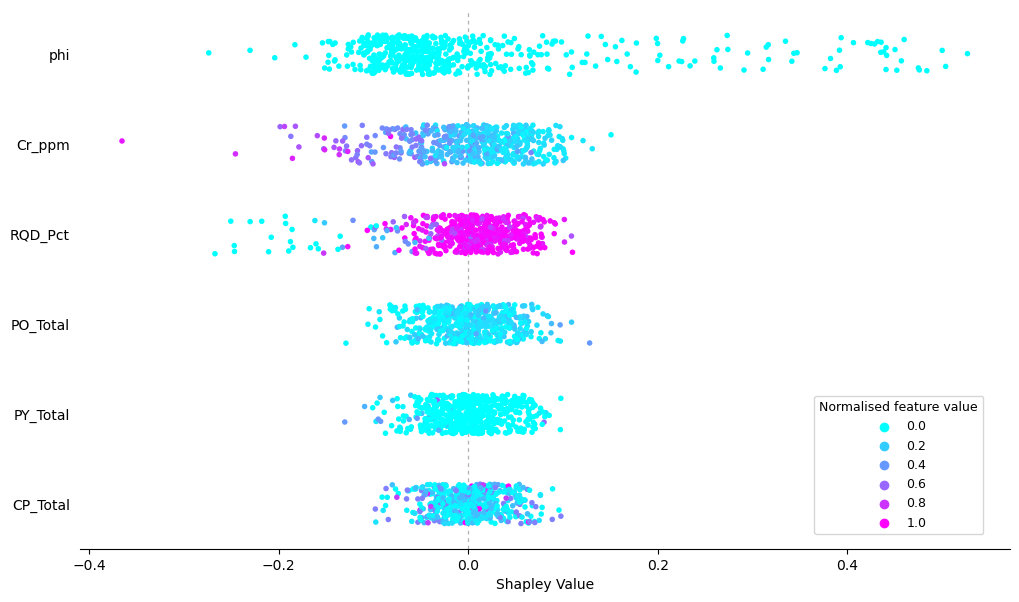

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

custom_colors = ["#00FFFF", "#FF00FF"]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_colors)

df_sv = pd.DataFrame()
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
df_sv['feature'] = sum([[feature] * len(X_test) for feature in features], [])
df_sv['shapley value'] = np.concatenate([psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm])
df_sv['hue'] = np.concatenate([X_test[feature].values for feature in features])

mean_df = pd.DataFrame()
mean_df['Mean'] = X_phi.mean(axis=1)
df_sv_phi = pd.DataFrame()
df_sv_phi["feature"] = ["phi"] * len(X_test)
df_sv_phi["shapley value"] = psi_phi
df_sv_phi['hue'] = mean_df['Mean'].values

df_sv = pd.concat([df_sv, df_sv_phi])

# Calculate the absolute sum of Shapley values for each feature
abs_sum_shapley = df_sv.groupby('feature')['shapley value'].apply(lambda x: np.sum(np.abs(x)))
feature_order = abs_sum_shapley.sort_values(ascending=False).index

# Sort the DataFrame based on the feature order
df_sv['feature'] = pd.Categorical(df_sv['feature'], categories=feature_order, ordered=True)
df_sv = df_sv.sort_values('feature')

# Beeswarm plot with custom colors
fig, ax = plt.subplots(figsize=(12, 7))  # Set the figure size (width, height)
ax.axvline(0, c="grey", alpha=0.6, linewidth=0.9, linestyle='--', dashes=(3, 3))
sns.stripplot(
    x=df_sv['shapley value'],
    y=df_sv['feature'],
    hue=df_sv['hue'],
    palette=custom_cmap,
    size=4,
    linewidth=0,  # Set linewidth for edges
    jitter=0.22  # Set linewidth for edges
)
ax.spines.left.set_visible(False)
ax.set_ylabel("")

#ax.set_yticklabels([r'$\phi$', 'Pyrrhotite', 'Rock Quality', 'Chromium', 'Chalcopyrite', 'Pyrite'])


# Increase x-axis and y-axis tick font size
ax.tick_params(axis='x', labelsize=10)  # Adjust the labelsize as needed
ax.tick_params(axis='y', labelsize=10)  # Adjust the labelsize as needed
ax.set_xlabel("Shapley Value", fontsize=10)

# Increase overall legend font size
legend = plt.legend(title='Normalised feature value', loc='upper right', bbox_to_anchor=(0.978, 0.295), borderaxespad=0.5, fontsize='9')
legend.get_title().set_fontsize('9') 
ax.spines.right.set_visible(False)  # Remove the right spine
ax.spines.top.set_visible(False)    # Remove the top spine
ax.tick_params(left=False, bottom=True)

plt.show()


In [47]:
df_sv['feature'].value_counts()

phi         524
Cr_ppm      524
RQD_Pct     524
PO_Total    524
PY_Total    524
CP_Total    524
Name: feature, dtype: int64

In [48]:
X_test

,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9,...,phi_482,phi_483,phi_484,phi_485,phi_486,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm
2240,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.050,0.020000,0.00,0.9930,0.144910
175,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.250,0.133333,0.00,0.9900,0.245509
1253,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.925,0.000000,0.00,0.9804,0.109581
1461,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.025,0.020000,0.00,0.9698,0.076048
2430,0.0,0.0,0.0,0.0,0.000027,0.000015,0.0,0.000137,0.038257,0.031329,...,0.0,0.0,0.0,0.0,0.0,0.000,0.013333,0.08,0.9351,0.904192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.125,0.133333,0.00,0.7801,0.476707
482,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.500,0.200000,0.00,0.9800,0.156886
1032,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.275,0.140000,0.00,0.9180,0.503593
438,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.045,0.030667,0.00,0.7375,0.443593


In [49]:
import pandas as pd


# FIX THIS, THE CONCATENATION ORDER IS NOT RIGHT

df_shapley = pd.DataFrame(X_test).reset_index(drop=True)

# Iterate over each unique feature
for feature_name in df_sv['feature'].unique():
    # Filter the DataFrame for the current feature
    filtered_df = df_sv.loc[df_sv['feature'] == feature_name].copy()
    
    filtered_df.columns = [f"{feature_name}-{col}" if col != 'feature' else col for col in filtered_df.columns]
    
    filtered_df = filtered_df.drop(columns=['feature']).reset_index(drop=True)
    
    df_shapley = pd.concat([df_shapley, filtered_df], axis=1)





In [50]:
df_shapley

,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9,...,Cr_ppm-shapley value,Cr_ppm-hue,RQD_Pct-shapley value,RQD_Pct-hue,PO_Total-shapley value,PO_Total-hue,PY_Total-shapley value,PY_Total-hue,CP_Total-shapley value,CP_Total-hue
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.040115,0.165988,0.029637,0.9863,-0.055499,0.013333,0.014708,0.00,0.019490,0.1500
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.074294,0.133832,-0.016993,0.8650,-0.033564,0.013333,-0.033864,0.00,-0.026765,0.0500
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.028053,0.145269,0.051204,0.9000,-0.003745,0.020000,-0.017013,0.00,-0.020575,0.0500
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,-0.046795,0.342515,0.004081,1.0000,-0.056648,0.020000,-0.029226,0.00,-0.036067,0.5000
4,0.0,0.0,0.0,0.0,0.000027,0.000015,0.0,0.000137,0.038257,0.031329,...,-0.062432,0.345395,-0.020022,0.9900,0.003706,0.066667,-0.045664,0.08,0.021668,0.0250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,-0.016243,0.171257,-0.007382,0.9569,0.001072,0.010667,0.014494,0.00,0.006261,0.2500
520,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.036634,0.085629,0.017952,0.9699,-0.018170,0.133333,0.077933,0.00,0.032089,0.0500
521,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,-0.028510,0.245509,0.037870,0.9400,0.025370,0.033333,0.052303,0.00,-0.039656,0.7500
522,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.074241,0.109581,0.044863,0.8741,0.026260,0.066667,0.014943,0.00,0.001595,0.1275


In [33]:
df_shapley.to_csv('df_shapley.csv', index=False)

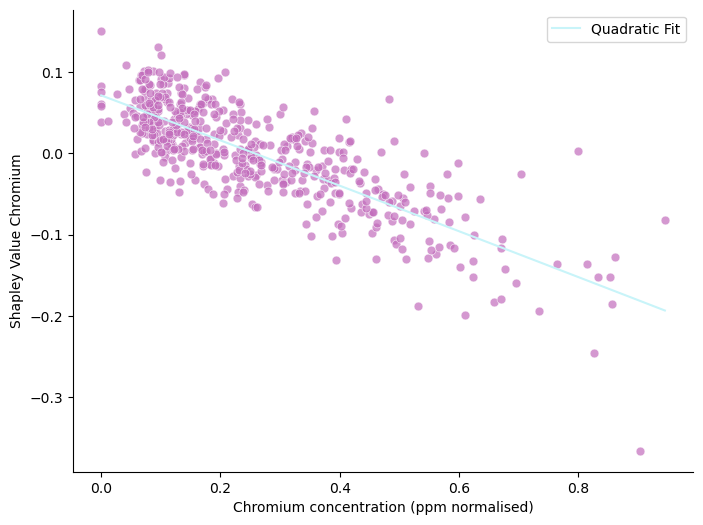

In [51]:
coefficients = np.polyfit(X_test['Cr_ppm'], psi_Cr_ppm, 2)
quadratic_curve = np.poly1d(coefficients)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test['Cr_ppm'], y=psi_Cr_ppm, s=40, alpha=0.7, color='#C26DBC')

x_values = np.linspace(min(X_test['Cr_ppm']), max(X_test['Cr_ppm']), 100)
plt.plot(x_values, quadratic_curve(x_values), color='#C8F4F9', linestyle='-', label='Quadratic Fit')

plt.xlabel('Chromium concentration (ppm normalised)', fontsize=10)
plt.ylabel('Shapley Value Chromium', fontsize=10)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.legend()  # Show legend
plt.savefig('Chromium dependence.png')  # Save the plot as PNG
plt.show()


In [55]:
import plotly.graph_objects as go
import pandas as pd



instance_idx = 11  
instance_row = X_test.iloc[instance_idx]

df_waterfall_combined = pd.DataFrame()

features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'phi']

df_waterfall_combined['feature'] = features
df_waterfall_combined['shapley value'] = [
    psi_CP_Total[instance_idx],
    psi_PO_Total[instance_idx],
    psi_PY_Total[instance_idx],
    psi_RQD_Pct[instance_idx],
    psi_Cr_ppm[instance_idx],
    psi_phi[instance_idx]  
]
df_waterfall_combined['source'] = ['Shapley'] * len(df_waterfall_combined)

fig_waterfall_combined = go.Figure()

mean_prediction = test_predictions.mean()

bar_sums = df_waterfall_combined['shapley value'].cumsum()

for source, color in zip(['Shapley'], ['#00FFFF']):
    source_df = df_waterfall_combined[df_waterfall_combined['source'] == source]
    symbols = ['triangle-right' if val >= 0 else 'triangle-left' for val in source_df['shapley value']]
    fig_waterfall_combined.add_trace(
        go.Waterfall(
            name=f"waterfall_{source}",
            orientation="h",
            y=source_df['feature'],
            x=source_df['shapley value'],
            base=mean_prediction,  # Set the base value
            decreasing=dict(marker=dict(color='#FF00FF')),
            increasing=dict(marker=dict(color='#00FFFF')),
            connector=dict(line=dict(color='rgba(128, 128, 128, 0.5)', width=1, dash='dot')),  # Adjust connector appearance
        )
    )

fig_waterfall_combined.update_layout(
    #title="Waterfall Plot for Shapley Values (Single Instance)",
    width=1000, height=500, font=dict(size=14),
    paper_bgcolor='rgba(0,0,0,0)',  
    plot_bgcolor='rgba(0,0,0,0)',  
    xaxis=dict(
        tickfont=dict(size=12, family='sans-serif', color='black'),
          # Make the x-axis ticks same size and color as y-axis
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=[0, 1, 2, 3, 4, 5],
        ticktext=['Chalcopyrite', 'Pyrrhotite', 'Pyrite', 'Rock Quality', 'Chromium', '𝝓'],
        tickfont=dict(size=12, family='sans-serif', color='black') 
    ),
    annotations=[
        dict(
            x=mean_prediction,
            y=-0.13,
            xref='x',
            yref='paper',
            text=f"E[f(X)] = {mean_prediction:.3f}",
            showarrow=False,
            font=dict(size=12, color='grey'),  
        ),
        dict(
            x= mean_prediction + bar_sums.iloc[-1],  
            y=1.1,
            xref='x',
            yref='paper',
            text=f"f(X) = {(mean_prediction + bar_sums.iloc[-1]):.3f}",
            showarrow=False,
            font=dict(size=12, color='grey'),  
        )
    ]
)

fig_waterfall_combined.update_xaxes(ticks="outside")

fig_waterfall_combined.add_shape(
    type="line",
    x0=0.37,
    y0=0,
    x1=0.651 ,
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)


fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction + bar_sums.iloc[-1],
    y0=0,
    x1=mean_prediction + bar_sums.iloc[-1],
    y1=1,
    line=dict(color="grey", width=0.5, dash="dot"),
    xref="x",
    yref="paper",
)

fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction + bar_sums.iloc[-1],
    y0=-0.01,
    x1=mean_prediction + bar_sums.iloc[-1],
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)

fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction,
    y0=-0.01,
    x1=mean_prediction,
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)


fig_waterfall_combined.write_html("waterfall.html")


In [56]:
df_waterfall_combined

,feature,shapley value,source
0,CP_Total,-0.073948,Shapley
1,PO_Total,-0.081259,Shapley
2,PY_Total,-0.069088,Shapley
3,RQD_Pct,-0.060711,Shapley
4,Cr_ppm,-0.087287,Shapley
5,phi,0.170948,Shapley


In [57]:
test_predictions.mean()

0.45818883

In [58]:
test_predictions[instance_idx]

0.6871151

In [61]:
test_predictions[instance_idx]  - test_predictions.mean()

0.22892624

In [60]:
test_predictions[instance_idx]

0.6871151